In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/im-p/csv/master/weight-height.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
import scipy.stats

def normal_distribution(r, f):
    r_x_min = r.min()
    r_x_max = r.max()
    f_x_min = f.min()
    f_x_max = f.max()

    r_mean = r.mean()
    r_std = r.std()
    f_mean = f.mean()
    f_std = f.std()

    r_x = np.linspace(r_x_min, r_x_max, 100)
    f_x = np.linspace(f_x_min, f_x_max, 100)

    r_y = scipy.stats.norm.pdf(r_x, r_mean, r_std)
    f_y = scipy.stats.norm.pdf(f_x, f_mean, f_std)

    plt.plot(r_x,r_y, color="coral", label = "real")
    plt.plot(f_x,f_y, color="green", label = "fake")
    #plt.scatter(r_x,r_y, color="coral", label = "real")
    #plt.scatter(f_x,f_y, color="green", label = "fake")
    plt.legend()
    plt.grid()

    print("--------real---------")
    print("mean:", r_mean, "\nstd:", r_std, "\nlen", len(r))
    print("--------fake---------")
    print("mean:", f_mean, "\nstd:", f_std, "\nlen", len(f))
    plt.title("Normal Distribution",fontsize=10, color="white")

    plt.show()

Using TensorFlow backend.


# Gan normaalijakauma


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1999 0.8057142857142857 0.822857140813555
--------real---------
mean: 79.6906014262103 
std: 86.38502410848686 
len 700
--------fake---------
mean: 41.406185 
std: 46.444927 
len 700


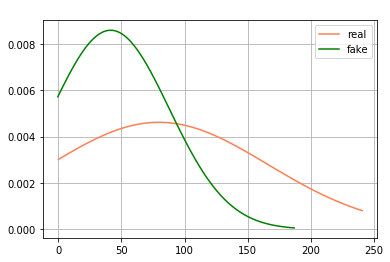

3999 0.58 0.7771428554398673
--------real---------
mean: 86.00275321943342 
std: 92.34881150389914 
len 700
--------fake---------
mean: 72.18357 
std: 76.21265 
len 700


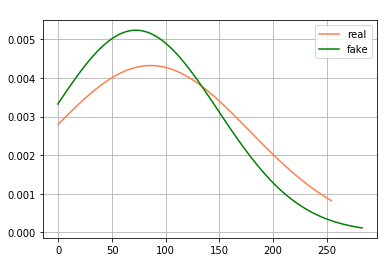

5999 0.13428571428571429 0.7685714295932224
--------real---------
mean: 80.63631664034925 
std: 86.10070067395495 
len 700
--------fake---------
mean: 93.16268 
std: 99.58372 
len 700


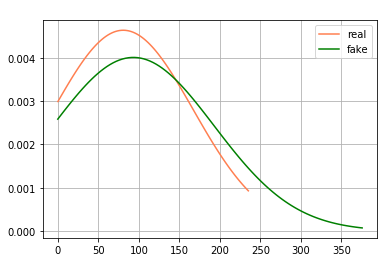

7999 0.0 1.0
--------real---------
mean: 88.05859985795664 
std: 93.91155417735492 
len 700
--------fake---------
mean: 105.250244 
std: 111.798454 
len 700


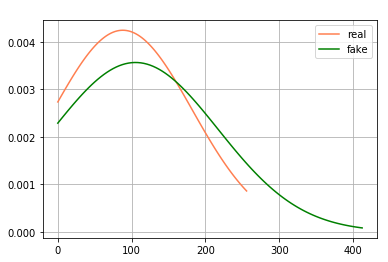

9999 1.0 0.2514285719394684
--------real---------
mean: 76.85505006381881 
std: 82.77082587581334 
len 700
--------fake---------
mean: 82.49023 
std: 87.622795 
len 700


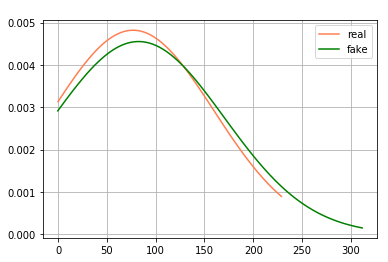

11999 0.0 1.0
--------real---------
mean: 81.91888002210324 
std: 87.94870552887383 
len 700
--------fake---------
mean: 78.93 
std: 83.422104 
len 700


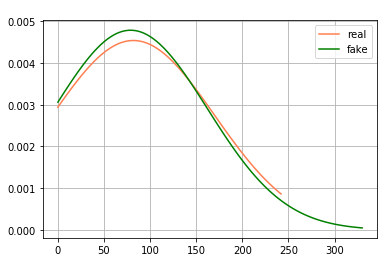

13999 0.88 0.777142858505249
--------real---------
mean: 86.97464060269319 
std: 95.44611634558728 
len 700
--------fake---------
mean: 84.22471 
std: 88.97479 
len 700


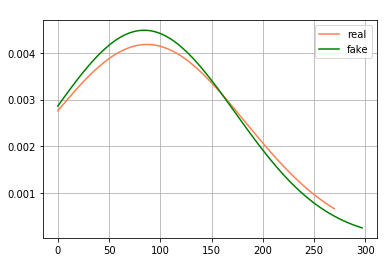

15999 0.2857142857142857 0.9257142840112959
--------real---------
mean: 79.7604579803696 
std: 84.794252085609 
len 700
--------fake---------
mean: 81.629684 
std: 86.881996 
len 700


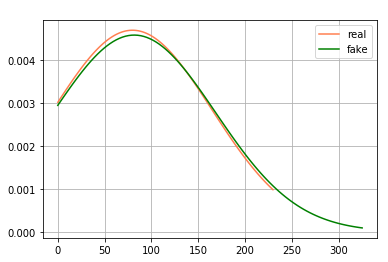

17999 0.0 1.0
--------real---------
mean: 79.56968411906539 
std: 84.88261955494978 
len 700
--------fake---------
mean: 83.084175 
std: 88.62309 
len 700


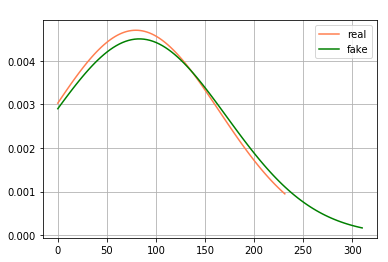

19999 1.0 0.9885714285714285
--------real---------
mean: 81.7091509094993 
std: 87.69092579270364 
len 700
--------fake---------
mean: 82.15082 
std: 88.10286 
len 700


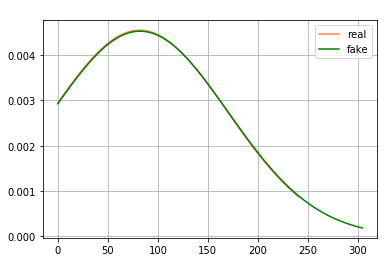

In [5]:
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25,  kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(LeakyReLU(alpha=0.01))
	model.add(Dense(15,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(alpha=0.01))
	model.add(Dense(10,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(alpha=0.01))
	model.add(Dense(5,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(alpha=0.01))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation="relu", kernel_initializer="he_uniform", input_dim=latent_dim))
	model.add(Dense(n_outputs, activation="linear"))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss="binary_crossentropy", optimizer="adam")
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs
	X1 = df.Weight.sample(n)
	#X1 = df.Weight.values[:n]
	#generate ouputs
	max = X1.max()
	min = X1.min()

	mean = X1.mean()
	std = X1.std()

	x = np.linspace(min, max, n)
	y = scipy.stats.norm.pdf(x, mean, std)
	
	X1 = x.reshape(n, 1)
	X2 = y.reshape(n, 1)
	X = hstack((X1, X2))
	y = ones((n, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	normal_distribution(x_real.flatten(),x_fake.flatten())
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=20000, n_batch=350, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator"s error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim, n_batch)
 
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)